# Forecasting Net Prophet

You’re a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/about-us). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. You've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, you want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

The instructions for this Challenge are divided into four steps, as follows:

* Step 1: Find unusual patterns in hourly Google search traffic

* Step 2: Mine the search traffic data for seasonality

* Step 3: Relate the search traffic to stock price patterns

* Step 4: Create a time series model with Prophet

The following subsections detail these steps.

## Install and import the required libraries and dependencies

In [51]:
# Import the required libraries and dependencies
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
%matplotlib inline

In [52]:

# Load the dataset, specifying the correct date format
df_mercado_trends = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/google_hourly_search_trends.csv",
    parse_dates=["Date"],  # Convert Date column to datetime
    date_format="%Y-%m-%d %H:%M:%S"  # Explicit date format
).dropna()

# Set "Date" as the index
df_mercado_trends.set_index("Date", inplace=True)

# Display first few rows
display(df_mercado_trends.head())
display(df_mercado_trends.tail())


,Search Trends
Date,
6/1/16 0:00,97
6/1/16 1:00,92
6/1/16 2:00,76
6/1/16 3:00,60
6/1/16 4:00,38


,Search Trends
Date,
9/7/20 20:00,71
9/7/20 21:00,83
9/7/20 22:00,96
9/7/20 23:00,97
9/8/20 0:00,96


In [53]:
# Reset the index and explicitly convert "Date" column to datetime
df_mercado_trends.reset_index(inplace=True)  # Temporarily move Date back to a column
df_mercado_trends["Date"] = pd.to_datetime(df_mercado_trends["Date"])  # Convert to datetime

# Set it back as the index
df_mercado_trends.set_index("Date", inplace=True)

# Confirm the change
print(df_mercado_trends.index.dtype)  # Should now be datetime64[ns]


/var/folders/c8/hb7hmlv175g9v_61s_1mf8xh0000gn/T/ipykernel_40422/3784018929.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mercado_trends["Date"] = pd.to_datetime(df_mercado_trends["Date"])  # Convert to datetime


datetime64[ns]


## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise? To answer this question, pick out any unusual patterns in the Google search data for the company, and connect them to the corporate financial events.

To do so, complete the following steps:

1. Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

2. Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?


In [54]:
# Slice the DataFrame to just the month of May 2020
df_may_2020 = df_mercado_trends.loc["2020-05"]

# Display the first and last few rows to confirm
display(df_may_2020.head())
display(df_may_2020.tail())


,Search Trends
Date,
2020-05-01 00:00:00,80
2020-05-01 01:00:00,80
2020-05-01 02:00:00,76
2020-05-01 03:00:00,66
2020-05-01 04:00:00,53


,Search Trends
Date,
2020-05-31 19:00:00,59
2020-05-31 20:00:00,64
2020-05-31 21:00:00,76
2020-05-31 22:00:00,90
2020-05-31 23:00:00,96


In [55]:
print(df_may_2020.columns)

Index(['Search Trends'], dtype='object')


#### Step 2: Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?

In [56]:
# Calculate the total search traffic for May 2020
traffic_may_2020 = df_may_2020["Search Trends"].sum()

# View the result
traffic_may_2020


38181

In [57]:
# Group the DataFrame by year and month, sum the search traffic, then compute the median
median_monthly_traffic = (
    df_mercado_trends.resample("ME")["Search Trends"].sum().median()
)

# View the result
median_monthly_traffic



35172.5

In [58]:
# Compare May 2020 traffic to the overall monthly median
traffic_comparison = traffic_may_2020/median_monthly_traffic

# View the result
traffic_comparison


1.0855355746677091

In [59]:
# Compare May 2020 traffic to the overall monthly median
traffic_comparison = traffic_may_2020/median_monthly_traffic

# View the result
traffic_comparison


1.0855355746677091

##### Answer the following question:

**Question:** Did the Google search traffic increase during the month that MercadoLibre released its financial results


**Answer:**  Yes, by about 8.5%

## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, you want to mine the search traffic data for predictable seasonal patterns of interest in the company. To do so, complete the following steps:

1. Group the hourly search data to plot the average traffic by the hour of day. Does the search traffic peak at a particular time of day or is it relatively consistent?

2. Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday). Does the search traffic get busiest on any particular day of the week?

3. Group the hourly search data to plot the average traffic by the week of the year. Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?


#### Step 1: Group the hourly search data to plot the average traffic by the hour of the day.

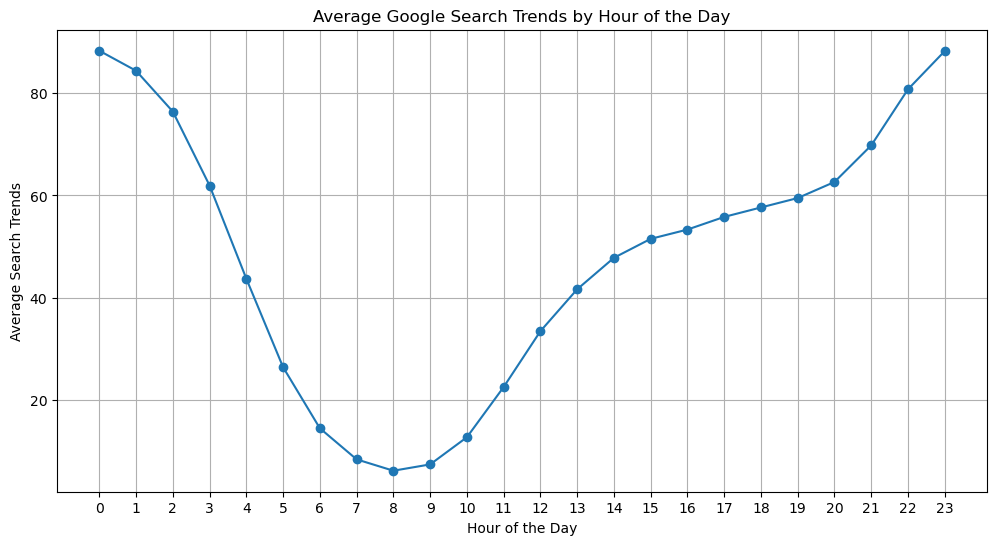

In [60]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.hour`
import matplotlib.pyplot as plt

# Extract the hour from the index
df_mercado_trends["Hour"] = df_mercado_trends.index.hour

# Group by hour and calculate the mean search traffic
hourly_avg_traffic = df_mercado_trends.groupby("Hour")["Search Trends"].mean()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(hourly_avg_traffic.index, hourly_avg_traffic, marker='o', linestyle='-')

# Formatting the plot
plt.xlabel("Hour of the Day")
plt.ylabel("Average Search Trends")
plt.title("Average Google Search Trends by Hour of the Day")
plt.xticks(range(0, 24))  # Show all 24 hours
plt.grid()

# Show the plot
plt.show()



#### Step 2: Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday).

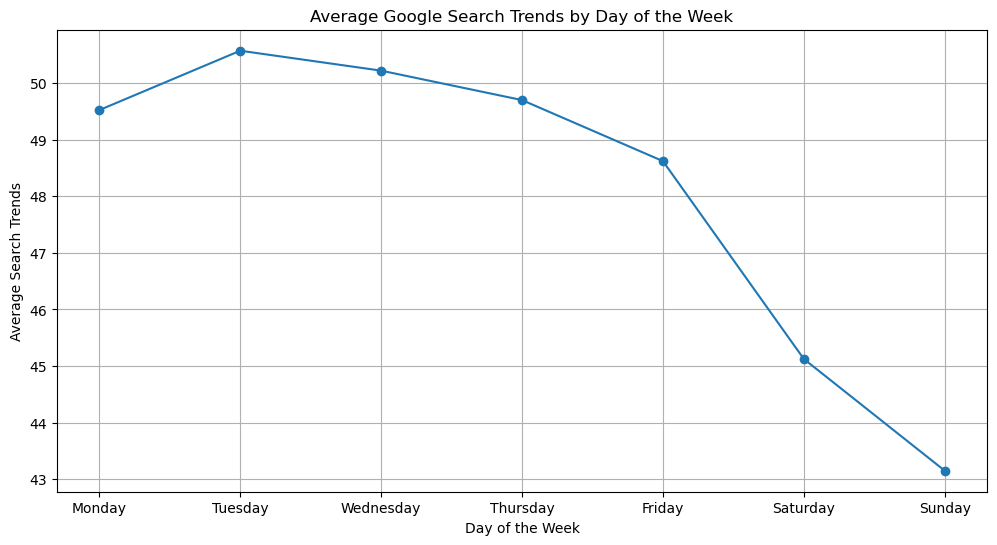

In [61]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.isocalendar().day`.
# Extract the day of the week (1 = Monday, 7 = Sunday)
df_mercado_trends["Day of Week"] = df_mercado_trends.index.isocalendar().day

# Group by day of the week and calculate the mean search traffic
daily_avg_traffic = df_mercado_trends.groupby("Day of Week")["Search Trends"].mean()

# Map numbers to actual day names
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
daily_avg_traffic.index = days  # Assign readable labels

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(daily_avg_traffic.index, daily_avg_traffic, marker='o', linestyle='-')

# Formatting the plot
plt.xlabel("Day of the Week")
plt.ylabel("Average Search Trends")
plt.title("Average Google Search Trends by Day of the Week")
plt.grid()

# Show the plot
plt.show()


#### Step 3: Group the hourly search data to plot the average traffic by the week of the year.

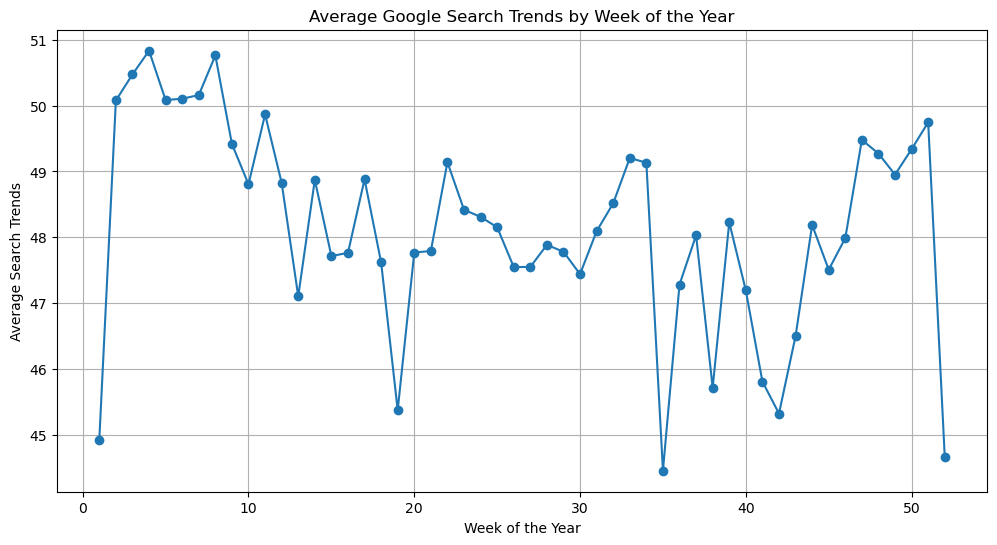

In [62]:
# Group the hourly search data to plot the average traffic by the week of the year using `df.index.isocalendar().week`.
# Extract the week number from the index
df_mercado_trends["Week of Year"] = df_mercado_trends.index.isocalendar().week

# Group by week and calculate the mean search traffic
weekly_avg_traffic = df_mercado_trends.groupby("Week of Year")["Search Trends"].mean()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(weekly_avg_traffic.index, weekly_avg_traffic, marker='o', linestyle='-')

# Formatting the plot
plt.xlabel("Week of the Year")
plt.ylabel("Average Search Trends")
plt.title("Average Google Search Trends by Week of the Year")
plt.grid()

# Show the plot
plt.show()


##### Answer the following question:

**Question:** Are there any time based trends that you can see in the data?

**Answer:**  Yes. Searches are lowest in the hours of 8-1 (Assume this is GMT, so overnight in Latin America.  Significantly higher weekdays - drops on Saturdays and significantly on Sundays. There are some signiciant weekly dups throughout the year - christmas holidays and week 18/36/42-3 - assume these are major holidays.

## Step 3: Relate the Search Traffic to Stock Price Patterns

You mention your work on the search traffic data during a meeting with people in the finance group at the company. They want to know if any relationship between the search data and the company stock price exists, and they ask if you can investigate.

To do so, complete the following steps:

1. Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

2. Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

3. Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

    * “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

    * “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis

4. Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?


#### Step 1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

In [63]:
# Upload the "mercado_stock_price.csv" file into Colab, then store in a Pandas DataFrame
# Set the "date" column as the Datetime Index.
df_mercado_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True
).dropna()

# View the first and last five rows of the DataFrame
display(df_mercado_stock.head())
display(df_mercado_stock.tail())

,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17


,close
date,
2020-07-31 11:00:00,1105.780
2020-07-31 12:00:00,1087.925
2020-07-31 13:00:00,1095.800
2020-07-31 14:00:00,1110.650
2020-07-31 15:00:00,1122.510


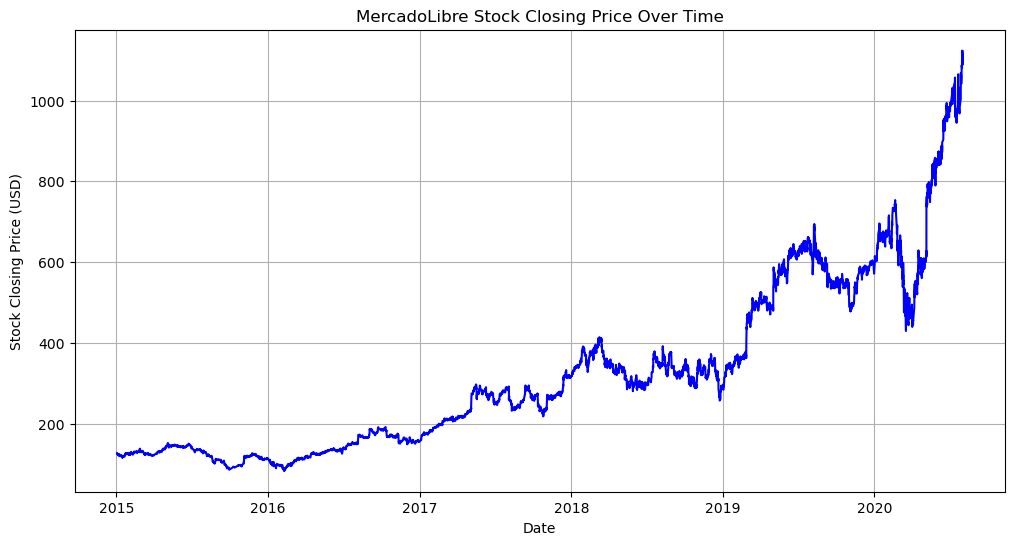

In [64]:
# Visualize the closing price of the df_mercado_stock DataFrame
# Plot the closing price of MercadoLibre stock
plt.figure(figsize=(12, 6))
plt.plot(df_mercado_stock.index, df_mercado_stock["close"], linestyle='-', color='blue')

# Formatting the plot
plt.xlabel("Date")
plt.ylabel("Stock Closing Price (USD)")
plt.title("MercadoLibre Stock Closing Price Over Time")
plt.grid()

# Show the plot
plt.show()


In [65]:
# Concatenate the df_mercado_stock DataFrame with the df_mercado_trends DataFrame
# Concatenate the DataFrame by columns (axis=1), and drop and rows with only one column of data
df_merged = pd.concat([df_mercado_stock, df_mercado_trends], axis=1).dropna()

# Display the first and last few rows to confirm
display(df_merged.head())
display(df_merged.tail())


,close,Search Trends,Hour,Day of Week,Week of Year
2016-06-01 09:00:00,135.16,6.0,9.0,3,22
2016-06-01 10:00:00,136.63,12.0,10.0,3,22
2016-06-01 11:00:00,136.56,22.0,11.0,3,22
2016-06-01 12:00:00,136.42,33.0,12.0,3,22
2016-06-01 13:00:00,136.10,40.0,13.0,3,22


,close,Search Trends,Hour,Day of Week,Week of Year
2020-07-31 11:00:00,1105.780,20.0,11.0,5,31
2020-07-31 12:00:00,1087.925,32.0,12.0,5,31
2020-07-31 13:00:00,1095.800,41.0,13.0,5,31
2020-07-31 14:00:00,1110.650,47.0,14.0,5,31
2020-07-31 15:00:00,1122.510,53.0,15.0,5,31


#### Step 2: Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

In [66]:
# For the combined dataframe, slice to just the first half of 2020 (2020-01 through 2020-06)
first_half_2020 = df_merged.loc["2020-01-01":"2020-06-30"]

# Display the first and last few rows to confirm
display(first_half_2020.head())
display(first_half_2020.tail())



,close,Search Trends,Hour,Day of Week,Week of Year
2020-01-02 09:00:00,601.085,9.0,9.0,4,1
2020-01-02 10:00:00,601.290,14.0,10.0,4,1
2020-01-02 11:00:00,615.410,25.0,11.0,4,1
2020-01-02 12:00:00,611.400,37.0,12.0,4,1
2020-01-02 13:00:00,611.830,50.0,13.0,4,1


,close,Search Trends,Hour,Day of Week,Week of Year
2020-06-30 11:00:00,976.17,17.0,11.0,2,27
2020-06-30 12:00:00,977.50,27.0,12.0,2,27
2020-06-30 13:00:00,973.23,37.0,13.0,2,27
2020-06-30 14:00:00,976.50,45.0,14.0,2,27
2020-06-30 15:00:00,984.93,51.0,15.0,2,27


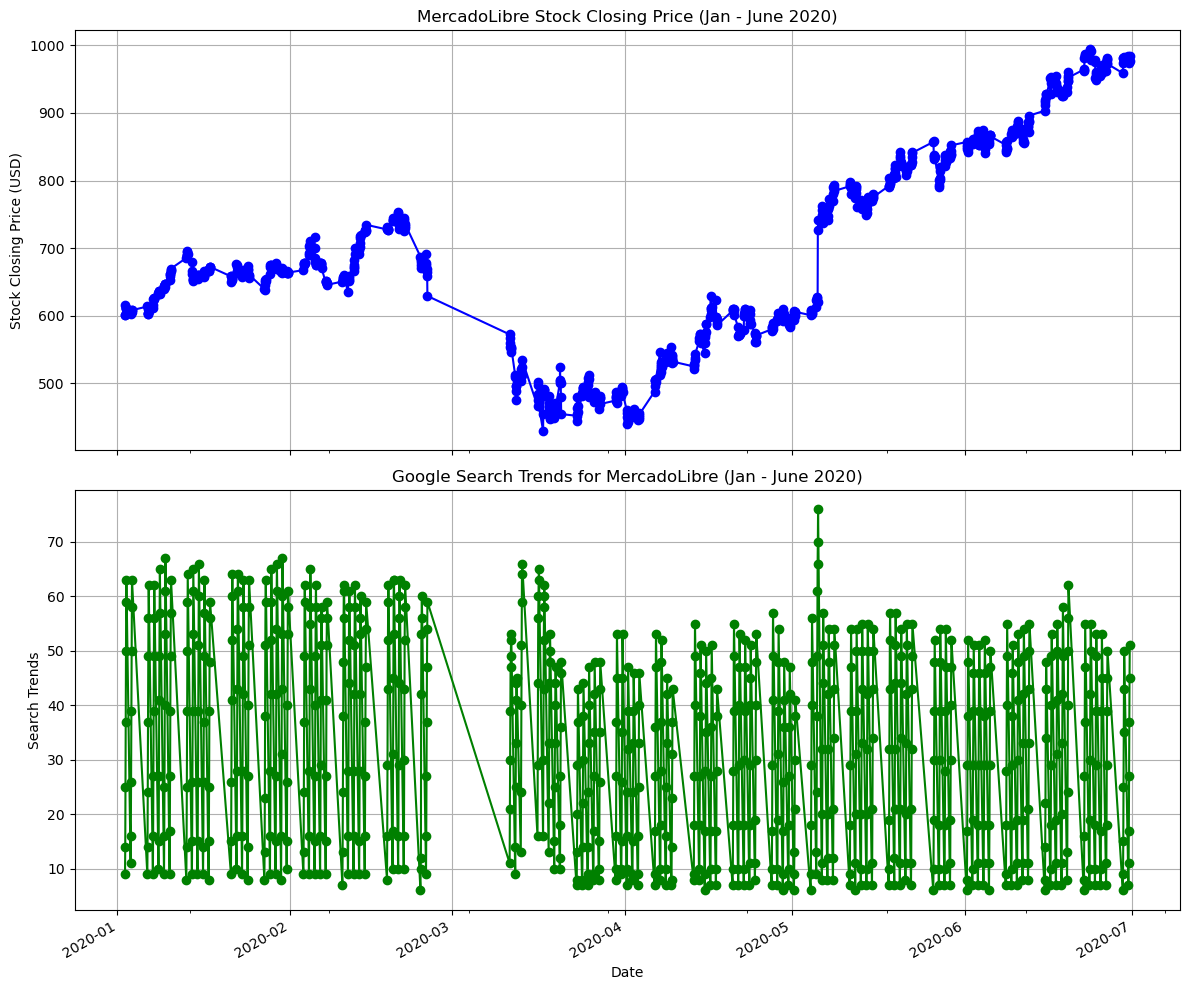

In [67]:
# Visualize the close and Search Trends data

# Create separate subplots for clarity
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

# Plot stock closing price
first_half_2020["close"].plot(ax=axes[0], marker='o', linestyle='-', color='blue')
axes[0].set_ylabel("Stock Closing Price (USD)")
axes[0].set_title("MercadoLibre Stock Closing Price (Jan - June 2020)")
axes[0].grid()

# Plot search trends
first_half_2020["Search Trends"].plot(ax=axes[1], marker='o', linestyle='-', color='green')
axes[1].set_ylabel("Search Trends")
axes[1].set_title("Google Search Trends for MercadoLibre (Jan - June 2020)")
axes[1].grid()

# Improve layout
plt.xlabel("Date")
plt.tight_layout()

# Show the plots
plt.show()




##### Answer the following question:

**Question:** Do both time series indicate a common trend that’s consistent with this narrative?

**Answer:** Yes - we see the dip (Covid) in March-April 2020, but then a return to consistent search volume and the stock price increased, reflecting consistent growth/sales performance.

#### Step 3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [68]:
# Create a new column in the mercado_stock_trends_df DataFrame called Lagged Search Trends
# This column should shift the Search Trends information by one hour

first_half_2020.loc[:, "Lagged Search Trends"] = first_half_2020["Search Trends"].shift(1)

# Display the first few rows to confirm
display(first_half_2020.head())



/var/folders/c8/hb7hmlv175g9v_61s_1mf8xh0000gn/T/ipykernel_40422/753779300.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_half_2020.loc[:, "Lagged Search Trends"] = first_half_2020["Search Trends"].shift(1)


,close,Search Trends,Hour,Day of Week,Week of Year,Lagged Search Trends
2020-01-02 09:00:00,601.085,9.0,9.0,4,1,NaN
2020-01-02 10:00:00,601.290,14.0,10.0,4,1,9.0
2020-01-02 11:00:00,615.410,25.0,11.0,4,1,14.0
2020-01-02 12:00:00,611.400,37.0,12.0,4,1,25.0
2020-01-02 13:00:00,611.830,50.0,13.0,4,1,37.0


In [69]:
# Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window

first_half_2020.loc[:, "Stock Volatility"] = first_half_2020["close"].pct_change().rolling(window=4).std()

# Display the first few rows to confirm
display(first_half_2020.head())


/var/folders/c8/hb7hmlv175g9v_61s_1mf8xh0000gn/T/ipykernel_40422/3215972671.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_half_2020.loc[:, "Stock Volatility"] = first_half_2020["close"].pct_change().rolling(window=4).std()


,close,Search Trends,Hour,Day of Week,Week of Year,Lagged Search Trends,Stock Volatility
2020-01-02 09:00:00,601.085,9.0,9.0,4,1,NaN,NaN
2020-01-02 10:00:00,601.290,14.0,10.0,4,1,9.0,NaN
2020-01-02 11:00:00,615.410,25.0,11.0,4,1,14.0,NaN
2020-01-02 12:00:00,611.400,37.0,12.0,4,1,25.0,NaN
2020-01-02 13:00:00,611.830,50.0,13.0,4,1,37.0,0.013082


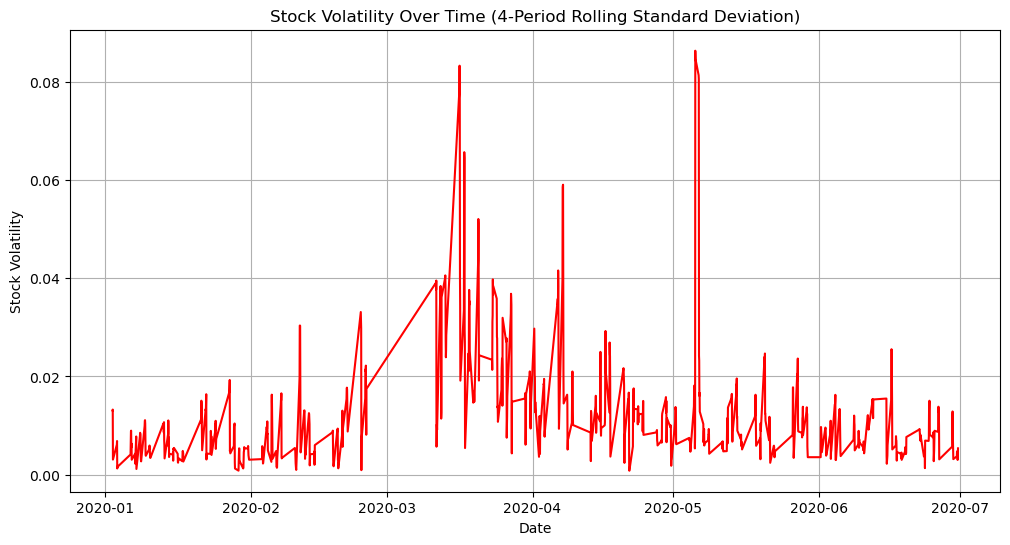

In [70]:
# Visualize the stock volatility

# Plot the stock volatility over time
plt.figure(figsize=(12, 6))
plt.plot(first_half_2020.index, first_half_2020["Stock Volatility"], linestyle='-', color='red')

# Formatting the plot
plt.xlabel("Date")
plt.ylabel("Stock Volatility")
plt.title("Stock Volatility Over Time (4-Period Rolling Standard Deviation)")
plt.grid()

# Show the plot
plt.show()



**Solution Note:** Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.

In [71]:
# Create a new column in the mercado_stock_trends_df DataFrame called Hourly Stock Return
# This column should calculate hourly return percentage of the closing price

first_half_2020.loc[:, "Hourly Stock Return"] = first_half_2020["close"].pct_change()

# Display the first few rows to confirm
display(first_half_2020.head())


/var/folders/c8/hb7hmlv175g9v_61s_1mf8xh0000gn/T/ipykernel_40422/3268781931.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_half_2020.loc[:, "Hourly Stock Return"] = first_half_2020["close"].pct_change()


,close,Search Trends,Hour,Day of Week,Week of Year,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2020-01-02 09:00:00,601.085,9.0,9.0,4,1,NaN,NaN,NaN
2020-01-02 10:00:00,601.290,14.0,10.0,4,1,9.0,NaN,0.000341
2020-01-02 11:00:00,615.410,25.0,11.0,4,1,14.0,NaN,0.023483
2020-01-02 12:00:00,611.400,37.0,12.0,4,1,25.0,NaN,-0.006516
2020-01-02 13:00:00,611.830,50.0,13.0,4,1,37.0,0.013082,0.000703


In [72]:
# View the first and last five rows of the mercado_stock_trends_df DataFrame
display(first_half_2020.head())
display(first_half_2020.tail())

,close,Search Trends,Hour,Day of Week,Week of Year,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2020-01-02 09:00:00,601.085,9.0,9.0,4,1,NaN,NaN,NaN
2020-01-02 10:00:00,601.290,14.0,10.0,4,1,9.0,NaN,0.000341
2020-01-02 11:00:00,615.410,25.0,11.0,4,1,14.0,NaN,0.023483
2020-01-02 12:00:00,611.400,37.0,12.0,4,1,25.0,NaN,-0.006516
2020-01-02 13:00:00,611.830,50.0,13.0,4,1,37.0,0.013082,0.000703


,close,Search Trends,Hour,Day of Week,Week of Year,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2020-06-30 11:00:00,976.17,17.0,11.0,2,27,11.0,0.004288,-0.002656
2020-06-30 12:00:00,977.50,27.0,12.0,2,27,17.0,0.004086,0.001362
2020-06-30 13:00:00,973.23,37.0,13.0,2,27,27.0,0.003014,-0.004368
2020-06-30 14:00:00,976.50,45.0,14.0,2,27,37.0,0.003557,0.003360
2020-06-30 15:00:00,984.93,51.0,15.0,2,27,45.0,0.005372,0.008633


#### Step 4: Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

In [73]:
# Construct correlation table of Stock Volatility, Lagged Search Trends, and Hourly Stock Return
correlation_table = first_half_2020[['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return']].corr()

# Display the correlation table
display(correlation_table)


,Stock Volatility,Lagged Search Trends,Hourly Stock Return
Stock Volatility,1.000000,-0.118094,0.048333
Lagged Search Trends,-0.118094,1.000000,-0.003399
Hourly Stock Return,0.048333,-0.003399,1.000000


##### Answer the following question:


**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

**Answer:**
This is not a strong correlation, so search traffic data alone does not appear to be a reliable indicator of the stock price.

## Step 4: Create a Time Series Model with Prophet

Now, you need to produce a time series model that analyzes and forecasts patterns in the hourly search data. To do so, complete the following steps:

1. Set up the Google search data for a Prophet forecasting model.

2. After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

3. Plot the individual time series components of the model to answer the following questions:

    * What time of day exhibits the greatest popularity?

    * Which day of the week gets the most search traffic?

    * What's the lowest point for search traffic in the calendar year?


#### Step 1: Set up the Google search data for a Prophet forecasting model.

In [74]:
# Using the df_mercado_trends DataFrame, reset the index so the date information is no longer the index

mercado_prophet_df = df_mercado_trends.reset_index()

# Label the columns ds and y so that the syntax is recognized by Prophet
mercado_prophet_df = mercado_prophet_df[["Date", "Search Trends"]]
mercado_prophet_df.columns = ["ds", "y"]  

# Drop an NaN values from the prophet_df DataFrame
mercado_prophet_df = mercado_prophet_df.dropna()

# View the first and last five rows of the mercado_prophet_df DataFrame
display(mercado_prophet_df.head())
display(mercado_prophet_df.tail())




,ds,y
0,2016-06-01 00:00:00,97
1,2016-06-01 01:00:00,92
2,2016-06-01 02:00:00,76
3,2016-06-01 03:00:00,60
4,2016-06-01 04:00:00,38


,ds,y
37101,2020-09-07 20:00:00,71
37102,2020-09-07 21:00:00,83
37103,2020-09-07 22:00:00,96
37104,2020-09-07 23:00:00,97
37105,2020-09-08 00:00:00,96


In [75]:
# Call the Prophet function, store as an object
# Install Prophet if it's not already installed
!pip install prophet


In [76]:
# Import Prophet
from prophet import Prophet

# Store Prophet as an object
model = Prophet()


In [77]:
# Fit the time-series model.
# Fit the model to the search trends data
model.fit(mercado_prophet_df)


19:37:51 - cmdstanpy - INFO - Chain [1] start processing
19:37:59 - cmdstanpy - INFO - Chain [1] done processing


In [78]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 2000 hours (approx 80 days)
future_mercado_trends = model.make_future_dataframe(periods=2000, freq="h")

# View the last five rows of the future_mercado_trends DataFrame
display(future_mercado_trends.tail())





,ds
39101,2020-11-30 04:00:00
39102,2020-11-30 05:00:00
39103,2020-11-30 06:00:00
39104,2020-11-30 07:00:00
39105,2020-11-30 08:00:00


In [79]:
# Make the predictions for the trend data using the future_mercado_trends DataFrame
forecast_mercado_trends = model.predict(future_mercado_trends)

# Display the first five rows of the forecast DataFrame
display(forecast_mercado_trends.head())



,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-06-01 00:00:00,44.129250,80.905317,98.362255,44.129250,44.129250,45.429305,45.429305,45.429305,41.452726,...,1.860133,1.860133,1.860133,2.116445,2.116445,2.116445,0.0,0.0,0.0,89.558555
1,2016-06-01 01:00:00,44.130313,77.662004,94.001393,44.130313,44.130313,41.875073,41.875073,41.875073,37.943506,...,1.810049,1.810049,1.810049,2.121518,2.121518,2.121518,0.0,0.0,0.0,86.005386
2,2016-06-01 02:00:00,44.131375,66.944655,84.392237,44.131375,44.131375,31.551566,31.551566,31.551566,27.656533,...,1.768474,1.768474,1.768474,2.126559,2.126559,2.126559,0.0,0.0,0.0,75.682942
3,2016-06-01 03:00:00,44.132438,51.136544,68.347591,44.132438,44.132438,16.284352,16.284352,16.284352,12.417280,...,1.735502,1.735502,1.735502,2.131569,2.131569,2.131569,0.0,0.0,0.0,60.416789
4,2016-06-01 04:00:00,44.133500,35.221658,51.814966,44.133500,44.133500,-0.830504,-0.830504,-0.830504,-4.678139,...,1.711088,1.711088,1.711088,2.136547,2.136547,2.136547,0.0,0.0,0.0,43.302997


#### Step 2: After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

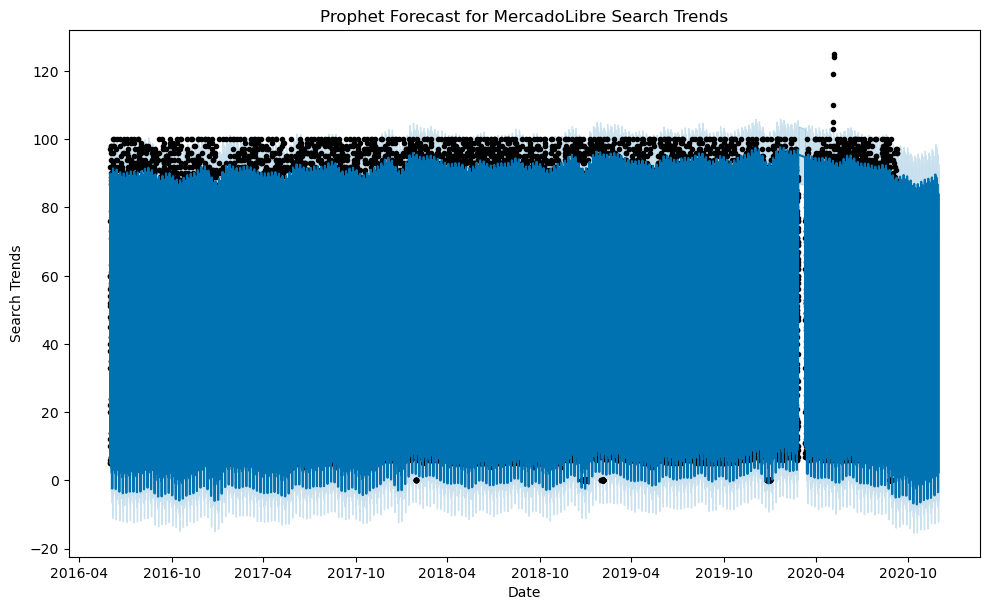

In [80]:
# Plot the Prophet forecast
fig = model.plot(forecast_mercado_trends)
plt.title("Prophet Forecast for MercadoLibre Search Trends")
plt.xlabel("Date")
plt.ylabel("Search Trends")
plt.grid()
plt.show()


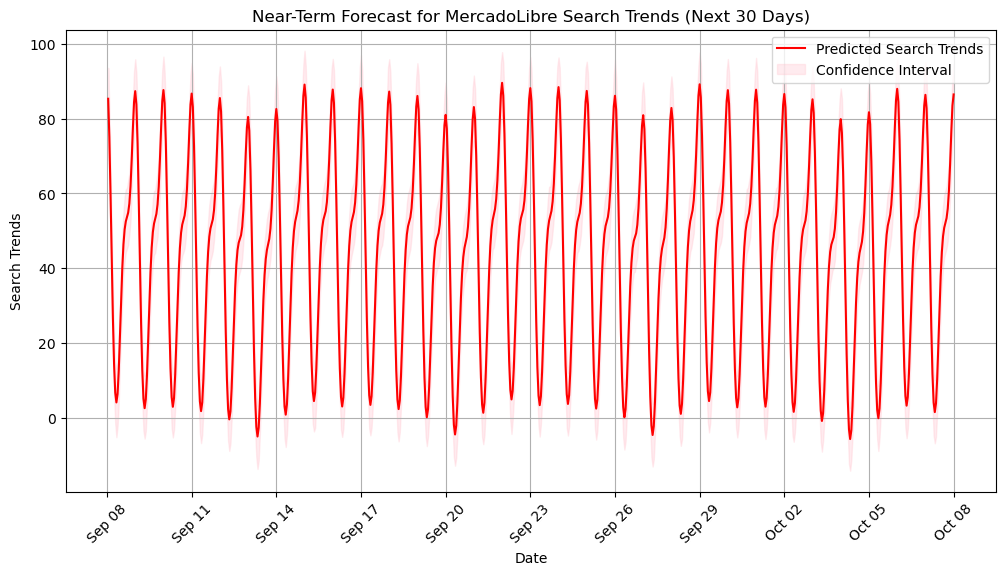

In [81]:
import matplotlib.dates as mdates

# Define the forecast horizon (e.g., next 30 days)
forecast_horizon = 30

# Get the last available historical date
latest_date = mercado_prophet_df["ds"].max()

# Filter forecasted data for only the next 30 days
forecast_near_term = forecast_mercado_trends[
    (forecast_mercado_trends["ds"] > latest_date) & 
    (forecast_mercado_trends["ds"] <= latest_date + pd.Timedelta(days=forecast_horizon))
]

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot only the near-term forecast
ax.plot(forecast_near_term["ds"], forecast_near_term["yhat"], label="Predicted Search Trends", color="red")

# Add confidence intervals for the near-term forecast
ax.fill_between(forecast_near_term["ds"], 
                forecast_near_term["yhat_lower"], 
                forecast_near_term["yhat_upper"], 
                color="pink", alpha=0.3, label="Confidence Interval")

# Formatting improvements
ax.set_title("Near-Term Forecast for MercadoLibre Search Trends (Next 30 Days)")
ax.set_xlabel("Date")
ax.set_ylabel("Search Trends")
ax.legend()
ax.grid()

# Improve x-axis readability
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))  # Show every 3rd day
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))  # Format as 'Month Day'
plt.xticks(rotation=45)  # Rotate dates for clarity

# Show the improved plot
plt.show()




##### Answer the following question:

**Question:**  How's the near-term forecast for the popularity of MercadoLibre?

**Answer:** Consistent.


#### Step 3: Plot the individual time series components of the model to answer the following questions:

* What time of day exhibits the greatest popularity? Midnight (which I think is around 5pm local time)

* Which day of the week gets the most search traffic? Tuesday

* What's the lowest point for search traffic in the calendar year? mid-late October


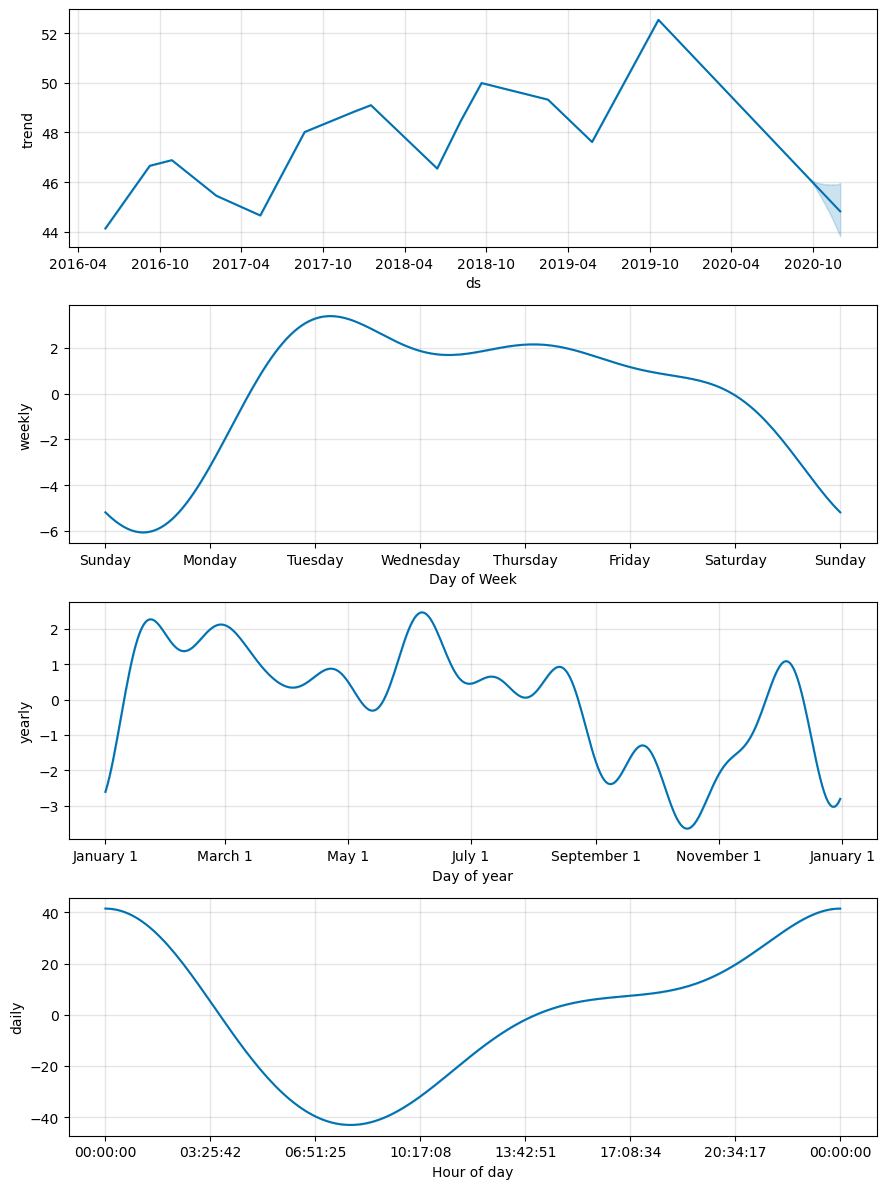

In [82]:
# Plot individual time series components (daily, weekly, yearly trends)
fig = model.plot_components(forecast_mercado_trends)
plt.show()


In [83]:
# Set the index in the forecast_mercado_trends DataFrame to the ds datetime column
forecast_mercado_trends.set_index("ds", inplace=True)

# View only the key forecasted columns
forecast_summary = forecast_mercado_trends[["yhat", "yhat_lower", "yhat_upper"]]

# Display the first and last few rows
display(forecast_summary.head())
display(forecast_summary.tail())



,yhat,yhat_lower,yhat_upper
ds,,,
2016-06-01 00:00:00,89.558555,80.905317,98.362255
2016-06-01 01:00:00,86.005386,77.662004,94.001393
2016-06-01 02:00:00,75.682942,66.944655,84.392237
2016-06-01 03:00:00,60.416789,51.136544,68.347591
2016-06-01 04:00:00,43.302997,35.221658,51.814966


,yhat,yhat_lower,yhat_upper
ds,,,
2020-11-30 04:00:00,39.283272,30.624389,48.359444
2020-11-30 05:00:00,23.812065,15.240696,31.945309
2020-11-30 06:00:00,11.846318,2.381563,20.852827
2020-11-30 07:00:00,4.574080,-4.172981,12.892440
2020-11-30 08:00:00,2.379109,-5.745558,11.013504


Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represents the worst and best case prediction (based on what are known as 95% confidence intervals).

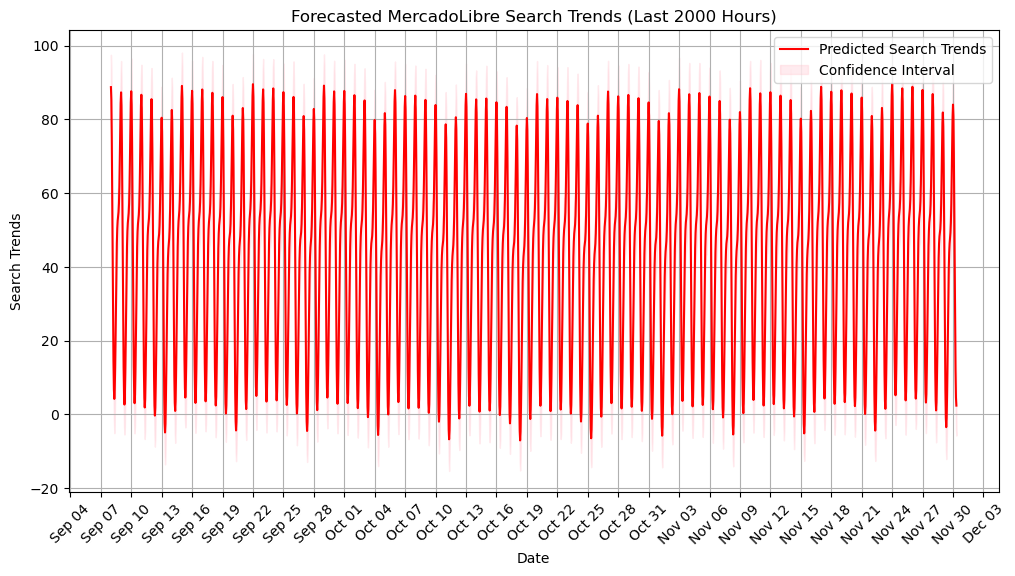

In [84]:
import matplotlib.dates as mdates

# Define how much past data to visualize (last 2000 hours)
past_horizon = 2000

# Get the latest date in the dataset
latest_date = forecast_mercado_trends.index.max()

# Filter the forecast data for the last 2000 hours
forecast_recent = forecast_mercado_trends[
    (forecast_mercado_trends.index >= latest_date - pd.Timedelta(hours=past_horizon))
]

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the predicted search trends (yhat)
ax.plot(forecast_recent.index, forecast_recent["yhat"], label="Predicted Search Trends", color="red")

# Plot the confidence interval (yhat_lower and yhat_upper)
ax.fill_between(forecast_recent.index, 
                forecast_recent["yhat_lower"], 
                forecast_recent["yhat_upper"], 
                color="pink", alpha=0.3, label="Confidence Interval")

# Formatting improvements
ax.set_title("Forecasted MercadoLibre Search Trends (Last 2000 Hours)")
ax.set_xlabel("Date")
ax.set_ylabel("Search Trends")
ax.legend()
ax.grid()

# Improve x-axis readability
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))  # Show every 3rd day
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))  # Format as 'Month Day'
plt.xticks(rotation=45)  # Rotate dates for clarity

# Show the plot
plt.show()



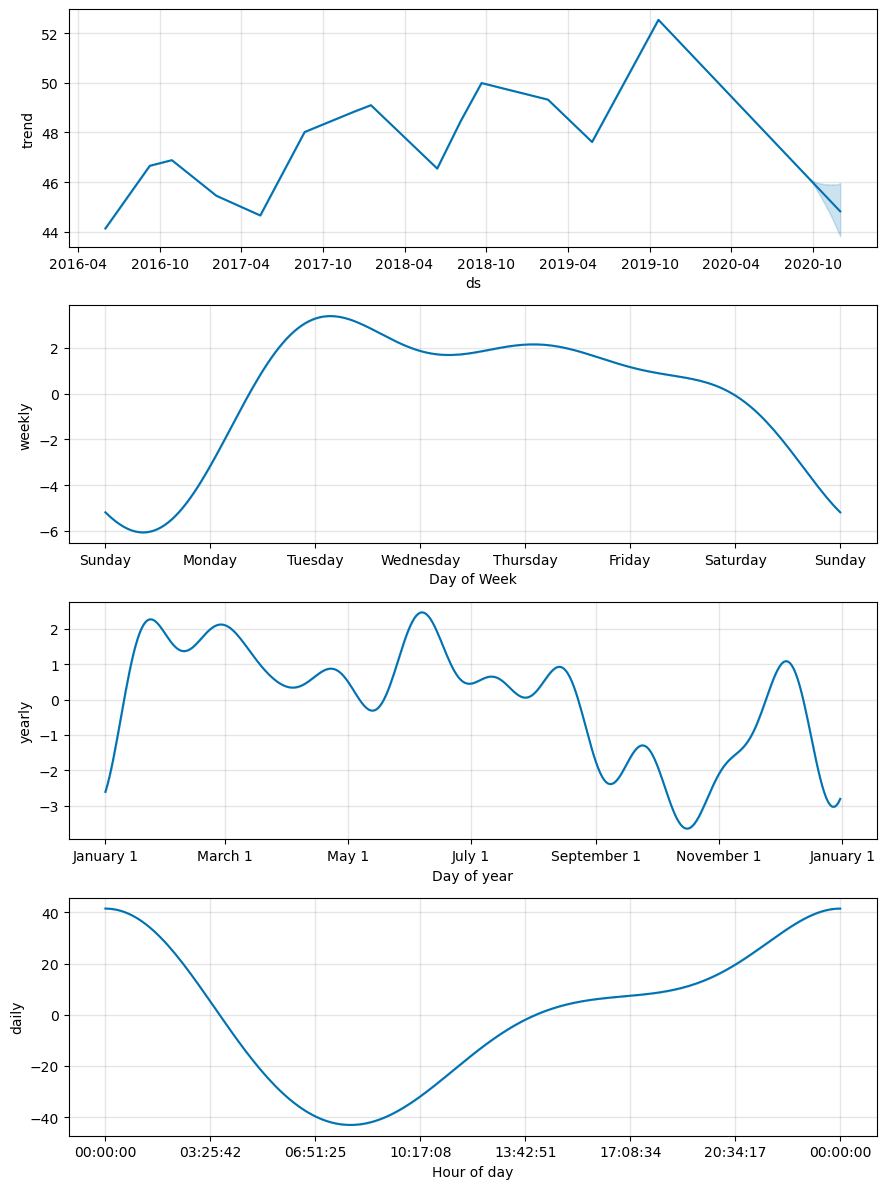

In [85]:
# Reset the index so "ds" becomes a regular column again
forecast_mercado_trends.reset_index(inplace=True)

# Use Prophet's plot_components function to visualize seasonal patterns
fig = model.plot_components(forecast_mercado_trends)
plt.show()



##### Answer the following questions:

**Question:** What time of day exhibits the greatest popularity?

**Answer:** Midnight (or 5-6 pm local time)

**Question:** Which day of week gets the most search traffic?
   
**Answer:** Tuesday

**Question:** What's the lowest point for search traffic in the calendar year?

**Answer:**
 Late October